# Population Segmentation: TF-IDF Features

## Objective

Author clustering Using their tweets.
TF-IDF as text features extraction

## Load the data

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

from utilities.load_tweets import load_tweets
from utilities.load_authors_data import load_authors_data

from time import time

import numpy as np

import pandas as pd

In [70]:
path = "data/pan15/english/"
authors_data = load_authors_data(path)

authors_data['tweet_text'] = authors_data['tweets'].apply(lambda x:" ".join(x))

In [3]:
authors_data.head()

,gender,age_group,extraverted,stable,agreeable,conscientious,open,tweets,tweet_text
user552,M,25-34,0.3,0.5,0.1,0.2,0.2,[How to Test Your Startup Idea for $50 http://...,How to Test Your Startup Idea for $50 http://t...
user865,M,25-34,0.2,0.4,0.2,0.0,0.2,[Everyday I come up with a new optimum solutio...,Everyday I come up with a new optimum solution...
user103,M,18-24,0.1,0.2,0.1,0.1,0.1,[@username @username @username @username #IfM...,@username @username @username @username #IfMy...
user179,F,18-24,0.1,0.1,-0.1,0.5,0.1,"[I wish we could talk forever.\t\t, 100000 thi...",I wish we could talk forever.\t\t 100000 thing...
user321,F,18-24,0.0,-0.1,0.1,0.3,0.4,"[icarly ^^\t\t, thuis<3\t\t, Homework finished...",icarly ^^\t\t thuis<3\t\t Homework finished.\t...


In [71]:
from utilities.clean_tweets import clean_tweets
authors_data['tweet_text_clean'] = authors_data['tweet_text'].apply(lambda text: clean_tweets(text))

## Extract TF-IDF Features

In [31]:
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS

n_features = 10000 # Maximum number of features (dimensions) to extract from text.
tfidf_vect = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf= True)


#TfidfVectorizer(min_df=opts.min,stop_words=set(my_stop_words),ngram_range=(1, opts.ngrammax))

# - count the word frequencies in the tweets
feats = tfidf_vect.fit_transform(authors_data['tweet_text_clean'])
    
dense = feats.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=tfidf_vect.get_feature_names())

# print son features info

print("Total number of features :", feats.shape[1])
print("Total number of rows:", feats.shape[0])

Total number of features : 6797
Total number of rows: 152


## Dimensionality reduction using Latent Semantic Analysis (LSA)

Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

In [16]:
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.


lsa_n_components = 2 #Preprocess documents with latent semantic analysis for dimentionality reduction
svd = TruncatedSVD(lsa_n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_lsa = lsa.fit_transform(feats)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Explained variance of the SVD step: 3%


## Find the optimal numbers of clusters

In [18]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_lsa)
    Sum_of_squared_distances.append(km.inertia_)

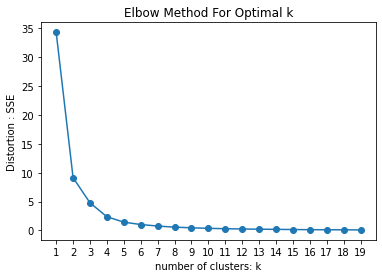

In [19]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, marker='o')
plt.xticks(K)
plt.xlabel('number of clusters: k')
plt.ylabel('Distortion : SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

**The Best Number of cluster could be 2, 3 or 4**

## Perform Author Clustering with k=2

In [20]:
 km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1,
                verbose=True)

In [104]:
y_km = km.fit_predict(X_lsa)

Initialization complete
Iteration 0, inertia 7.810190253160633
Iteration 1, inertia 6.042606785594324
Iteration 2, inertia 5.681628372625278
Iteration 3, inertia 5.484590110198859
Iteration 4, inertia 5.286917829294011
Iteration 5, inertia 5.128424536234801
Iteration 6, inertia 4.971720110071897
Iteration 7, inertia 4.968448754454028
Converged at iteration 7: center shift 0.0 within tolerance 1.1287967437805055e-05


### Cluster Visualization

In [105]:
s=  X_lsa[((y_km == 0) & (authors_data['gender']=='M')), 0]
s.shape

(17,)

In [106]:
y=  X_lsa[authors_data['gender']=='M', 0]
y.shape

(76,)

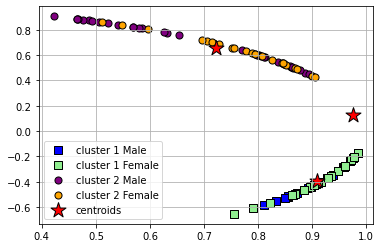

In [107]:


import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go

# plot the 2 clusters
plt.scatter(
    X_lsa[((y_km == 0) & (authors_data['gender']=='M')), 0], X_lsa[((y_km == 0) & (authors_data['gender']=='M')), 1],
    s=50, c='blue',
    marker='s', edgecolor='black',
    label='cluster 1 Male'
)

plt.scatter(
    X_lsa[((y_km == 0) & (authors_data['gender']=='F')), 0], X_lsa[((y_km == 0) & (authors_data['gender']=='F')), 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1 Female'
)

plt.scatter(
    X_lsa[((y_km == 1) & (authors_data['gender']=='M')), 0], X_lsa[((y_km == 1) & (authors_data['gender']=='M')), 1],
    s=50, c='purple',
    marker='o', edgecolor='black',
    label='cluster 2 Male'
)

plt.scatter(
    X_lsa[((y_km == 1) & (authors_data['gender']=='F')), 0], X_lsa[((y_km == 1) & (authors_data['gender']=='F')), 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2 Female'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## Perform Author Clustering with k=3

In [98]:
 km = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1,
                verbose=True)

In [99]:
y_km = km.fit_predict(X_lsa)

Initialization complete
Iteration 0, inertia 7.360856472178648
Iteration 1, inertia 5.00917301185674
Iteration 2, inertia 4.978831080181442
Iteration 3, inertia 4.973199464134643
Iteration 4, inertia 4.963809478386415
Iteration 5, inertia 4.955395030991867
Iteration 6, inertia 4.938002452677523
Iteration 7, inertia 4.915998047498054
Iteration 8, inertia 4.8865749489976755
Iteration 9, inertia 4.855184626791145
Iteration 10, inertia 4.851886035411765
Converged at iteration 10: center shift 0.0 within tolerance 1.1287967437805055e-05


### Plot the clusters

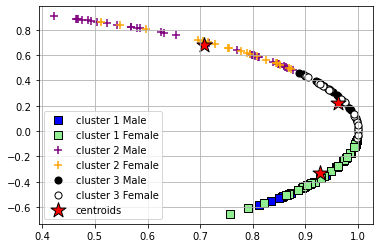

In [102]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go

# plot the 2 clusters
plt.scatter(
    X_lsa[((y_km == 0) & (authors_data['gender']=='M')), 0], X_lsa[((y_km == 0) & (authors_data['gender']=='M')), 1],
    s=50, c='blue',
    marker='s', edgecolor='black',
    label='cluster 1 Male'
)

plt.scatter(
    X_lsa[((y_km == 0) & (authors_data['gender']=='F')), 0], X_lsa[((y_km == 0) & (authors_data['gender']=='F')), 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1 Female'
)

plt.scatter(
    X_lsa[((y_km == 1) & (authors_data['gender']=='M')), 0], X_lsa[((y_km == 1) & (authors_data['gender']=='M')), 1],
    s=50, c='purple',
    marker='+', edgecolor='black',
    label='cluster 2 Male'
)

plt.scatter(
    X_lsa[((y_km == 1) & (authors_data['gender']=='F')), 0], X_lsa[((y_km == 1) & (authors_data['gender']=='F')), 1],
    s=50, c='orange',
    marker='+', edgecolor='black',
    label='cluster 2 Female'
)

plt.scatter(
    X_lsa[((y_km == 2) & (authors_data['gender']=='M')), 0], X_lsa[((y_km == 2) & (authors_data['gender']=='M')), 1],
    s=50, c='black',
    marker='o', edgecolor='black',
    label='cluster 3 Male'
)

plt.scatter(
    X_lsa[((y_km == 2) & (authors_data['gender']=='F')), 0], X_lsa[((y_km == 2) & (authors_data['gender']=='F')), 1],
    s=50, c='white',
    marker='o', edgecolor='black',
    label='cluster 3 Female'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

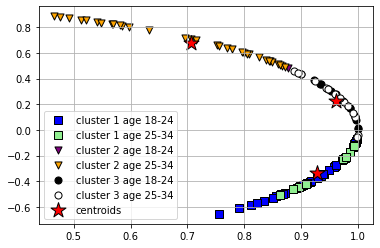

In [103]:


import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go

# plot the 2 clusters
plt.scatter(
    X_lsa[((y_km == 0) & (authors_data['age_group']=='18-24')), 0], X_lsa[((y_km == 0) & (authors_data['age_group']=='18-24')), 1],
    s=50, c='blue',
    marker='s', edgecolor='black',
    label='cluster 1 age 18-24'
)

plt.scatter(
    X_lsa[((y_km == 0) & (authors_data['age_group']=='25-34')), 0], X_lsa[((y_km == 0) & (authors_data['age_group']=='25-34')), 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1 age 25-34'
)



plt.scatter(
    X_lsa[((y_km == 1) & (authors_data['age_group']=='18-24')), 0], X_lsa[((y_km == 1) & (authors_data['age_group']=='18-24')), 1],
    s=50, c='purple',
    marker='v', edgecolor='black',
    label='cluster 2 age 18-24'
)

plt.scatter(
    X_lsa[((y_km == 1) & (authors_data['age_group']=='25-34')), 0], X_lsa[((y_km == 1) & (authors_data['age_group']=='25-34')), 1],
    s=50, c='orange',
    marker='v', edgecolor='black',
    label='cluster 2 age 25-34'
)

plt.scatter(
    X_lsa[((y_km == 2) & (authors_data['age_group']=='18-24')), 0], X_lsa[((y_km == 2) & (authors_data['age_group']=='18-24')), 1],
    s=50, c='black',
    marker='o', edgecolor='black',
    label='cluster 3 age 18-24'
)

plt.scatter(
    X_lsa[((y_km == 2) & (authors_data['age_group']=='25-34')), 0], X_lsa[((y_km == 2) & (authors_data['age_group']=='25-34')), 1],
    s=50, c='white',
    marker='o', edgecolor='black',
    label='cluster 3 age 25-34'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## Perform Author Clustering with k=4

In [94]:
km = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1,
                verbose=True)

In [95]:
y_km = km.fit_predict(X_lsa)

Initialization complete
Iteration 0, inertia 2.626310485645717
Iteration 1, inertia 2.3814118956576236
Converged at iteration 1: center shift 0.0 within tolerance 1.1287967437805055e-05


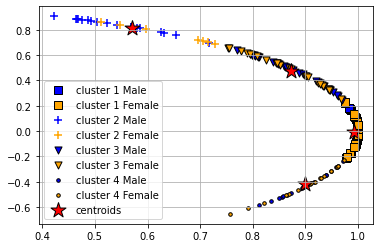

In [97]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go

# plot the 2 clusters
plt.scatter(
    X_lsa[((y_km == 0) & (authors_data['gender']=='M')), 0], X_lsa[((y_km == 0) & (authors_data['gender']=='M')), 1],
    s=50, c='blue',
    marker='s', edgecolor='black',
    label='cluster 1 Male'
)

plt.scatter(
    X_lsa[((y_km == 0) & (authors_data['gender']=='F')), 0], X_lsa[((y_km == 0) & (authors_data['gender']=='F')), 1],
    s=50, c='orange',
    marker='s', edgecolor='black',
    label='cluster 1 Female'
)

plt.scatter(
    X_lsa[((y_km == 1) & (authors_data['gender']=='M')), 0], X_lsa[((y_km == 1) & (authors_data['gender']=='M')), 1],
    s=50, c='blue',
    marker='+', edgecolor='black',
    label='cluster 2 Male'
)

plt.scatter(
    X_lsa[((y_km == 1) & (authors_data['gender']=='F')), 0], X_lsa[((y_km == 1) & (authors_data['gender']=='F')), 1],
    s=50, c='orange',
    marker='+', edgecolor='black',
    label='cluster 2 Female'
)

plt.scatter(
    X_lsa[((y_km == 2) & (authors_data['gender']=='M')), 0], X_lsa[((y_km == 2) & (authors_data['gender']=='M')), 1],
    s=50, c='blue',
    marker='v', edgecolor='black',
    label='cluster 3 Male'
)

plt.scatter(
    X_lsa[((y_km == 2) & (authors_data['gender']=='F')), 0], X_lsa[((y_km == 2) & (authors_data['gender']=='F')), 1],
    s=50, c='orange',
    marker='v', edgecolor='black',
    label='cluster 3 Female'
)

plt.scatter(
    X_lsa[((y_km == 3) & (authors_data['gender']=='M')), 0], X_lsa[((y_km == 3) & (authors_data['gender']=='M')), 1],
    s=50, c='blue',
    marker='.', edgecolor='black',
    label='cluster 4 Male'
)

plt.scatter(
    X_lsa[((y_km == 3) & (authors_data['gender']=='F')), 0], X_lsa[((y_km == 3) & (authors_data['gender']=='F')), 1],
    s=50, c='orange',
    marker='.', edgecolor='black',
    label='cluster 4 Female'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()